In [845]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import collections as mc
import statistics
import datetime as dt
plt.ioff()

Q1 = 25
Q2 = 50
Q3 = 75


#Dump events & drop useless columns
dump_arrival = pd.read_csv('../../data/interm_data/filtered_skip_deliveries_at_Mzedi.csv')
dump_arrival = dump_arrival.drop(columns=['end','deviceid', 'start'])

#List of origin points
list_origin = dump_arrival.skip_origin.unique().astype(str)
list_origin = list_origin[list_origin!= 'nan']

#Datetime conversion and sorting
dump_arrival.date = pd.to_datetime(dump_arrival.date)#.dt.tz_localize('Africa/Mbabane')
dump_arrival = dump_arrival.sort_values('date')

## PIVOT TABLE
dump_arrival_new = dump_arrival.copy()
dump_arrival_new['values'] = 1
pivot_dump = pd.pivot_table(dump_arrival_new,values='values',index=['date'],columns='skip_origin',aggfunc=np.sum, fill_value=0)

In [846]:
# print(list_origin)
# print(skip_dfCol)

In [847]:
## Defined for a specific area: NAIZI
## Arrival indices from list_origin: Naizi market: 32
## Ramps indices from skip_dfCol: Naizi_inorganic_1: 9
list_origin_indices = [32]
skip_dfCol_indices = [9]
spike_removal = True

In [848]:
## Defined for a specific area: BCA
## Arrival indices from list_origin: BCA market: 33;
## Ramps indices from skip_dfCol: BCA_inorganic_1: 6; BCA_inorganic_2: 7
list_origin_indices = [33]
skip_dfCol_indices = [6,7]
spike_removal = True

In [849]:
## Defined for a specific area: BANGWE
## Arrival indices from list_origin: Bangwe ground: 11; Bangwe market: 18;
## Ramps indices from skip_dfCol: Bangwe_inorganic_1: 2; Bangwe_inorganic_2: 3
list_origin_indices = [11,18]
skip_dfCol_indices = [2,3]
spike_removal = False

In [850]:
## Check
# print((list_origin[list_origin_indices]))
# print(skip_dfCol[skip_dfCol_indices])

In [851]:
## TIMELINE PLOT
plt.close('all')
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)

arrivals_data = pd.DataFrame(columns = list_origin[list_origin_indices])

all_arrival_dates = 0
style = 0
styles = ['dashed','dotted','solid']
title_plt = ""
for i in list_origin_indices:
    current_indices = pivot_dump[pivot_dump[list_origin[i]]!=0].index
    ax.vlines(current_indices, 0, 1, linestyle=styles[style], color=[(0, 0, 0, 0.5)], linewidth=1,label=list_origin[i]+" arrivals")  # The vertical stems
    ax.plot(current_indices, np.zeros_like(current_indices), "-", color='gray')  #Tick plot
    if type(all_arrival_dates) is not int:
        all_arrival_dates = all_arrival_dates.append(current_indices)
    else:
        all_arrival_dates = current_indices
    style = style+1
    
for i in list_origin_indices:
    if i == list_origin_indices[-1]:
        title_plt = title_plt + list_origin[i]
    else:
        title_plt = title_plt + list_origin[i] + " & "
        
plt.title(title_plt)

min_date_arrival = min(all_arrival_dates)
max_date_arrival = max(all_arrival_dates)


ax.yaxis.set_visible(False) #Hide y axis
ax.spines[["left", "top", "right"]].set_visible(False)#Hide other lines
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) #Month interval labels
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.grid(False)
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
print([])
#plt.show() #Plot


[]


In [852]:
#Extract CSV filling data. Each column is a different skip
skip_filling_df = pd.read_csv('../../data/raw_data/Skip-fullness-blantyre-raw.csv')

#Setting the index of the dataframe to the date and convert to datetime
skip_filling_df.set_index('date', inplace=True)
skip_filling_df.index = pd.to_datetime(skip_filling_df.index)


#Remove '.' and dates with all NaN values, convert all to float
skip_filling_df = skip_filling_df.replace('.', np.nan)
skip_filling_df = skip_filling_df.astype(float)
na_columns = skip_filling_df.sum(axis = 0)[skip_filling_df.sum(axis = 0) == 0].index.tolist()
skip_filling_df.dropna(axis=1, how='all', inplace=True)


#List of the skips
skip_dfCol = skip_filling_df.columns

#Number of columns, or skips
numSkips = len(skip_dfCol)

skip_filling_df = skip_filling_df.copy()
skip_filling_df[skip_filling_df < 8] *= 4 / 7
skip_filling_df[skip_filling_df == 8] = 5
min_plot_y = -0.5
max_plot_y = 5.5

In [853]:
##########################################
## Ramp detection and profile extraction
##
## Goals: 
##     - Remove spikes
##    - Detect end of top of ramps, then beginning
##     - Remove derating increases
##     - Find start of ramps 
##
##    VARIATION: only output the bottoms which are not the first value
##########################################
ramps_empty_events = pd.DataFrame(columns = skip_dfCol[skip_dfCol_indices])

for binNum in skip_dfCol_indices: #range(len(skip_filling_df.columns)):
    skip_filling_interest = skip_filling_df[skip_dfCol[binNum]].copy().dropna() #Drops NaN from the df
    diff_pos = skip_filling_interest.diff() #difference val(n) - val(n-1) #Get the difference in fullness between subsequent datapoints
    diff_neg = skip_filling_interest.diff(periods=-1) #difference val(n) - val(n+1) #Get the difference in the negative direction
    td_1 = pd.Timedelta(1, "d") #Define 1 days as a timedelta (pandas tool)


    ## Removing 1 day back to original spikes (positive and negative) Forward pass
    # diff_index_pos = skip_filling_interest.index.to_series().diff() #Index difference between  points (important for NaN)
    # diff_index_neg = skip_filling_interest.index.to_series().diff(periods=-1)
    if spike_removal:
        skip_filling_interest_no_spike = skip_filling_interest.copy().drop(skip_filling_interest[diff_pos - diff_neg == 0][diff_pos != 0].index)#[diff_index_pos == td_1][diff_index_neg == -td_1])
    else:
        skip_filling_interest_no_spike = skip_filling_interest.copy()

    ## Top ends - forward pass
    indices_no_spike = skip_filling_interest_no_spike.index #Get indices for the current working df series

    i = 0 #Counting
    imax = 0 #Loop protection variable

    top_ends = pd.DataFrame(columns=['top_ends']) #df with the ending of top of ramps
    while i <= len(indices_no_spike) and imax < 600:
        imax = imax+1
        for j in range(len(indices_no_spike)-i-1):
            if skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] >= skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]:
                if i+j+1 == len(indices_no_spike)-1:
                    top_ends.loc[indices_no_spike[i+j+1]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]]
                    i = i+j+1
                    break
                elif skip_filling_interest_no_spike.loc[indices_no_spike[i+j]] == 4 and skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] == 5:
                    top_ends.loc[indices_no_spike[i+j]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]
                    imax2 = 0
                    while  i+j+1 <= len(indices_no_spike)-1 and skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] == 5 and imax2 < 600:
                        imax2 = imax2+1
                        if i+j+1 <= len(indices_no_spike)-1:
                            j = j+1
                        else:
                            break
                    i = i + j + 1
                    break
                else:
                    pass
            else:
                top_ends.loc[indices_no_spike[i+j]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]
                i = i+j+1
                break



    ## Move top ends to top beginnings, eliminates plateau from analysis. Backward pass
    top_beginnings = pd.DataFrame(columns=['top_beginnings'])
    i = len(top_ends)-1
    imax = 0
    while i >= 0 and imax < 600:
        imax = imax+1
        for j in range(indices_no_spike.get_loc(top_ends.index[i])):
            if skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j-1]] == skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]:
                pass
            elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j-1]] < skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]:
                top_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]
                i = i - 1
                #add to list 
                break
            else:
                i = i - 1
                break


    ## Remove derating (backward pass)
    top_beginnings_no_derating = pd.DataFrame(columns=['top_beginnings_no_derating'])
    i = len(top_beginnings[top_beginnings==5])-1
    imax = 0
    while i >= 0 and imax < 600:
        imax = imax+1
        for j in range(indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])):
            if skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])-j-1]] == 4:
                pass
            elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])-j-1]] < 4:
                top_beginnings_no_derating.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])]]
                i = i - 1
                #add to list 
                break
            else:
                i = i - 1
                break

    ## Find bottoms (backward pass) walk back for as long as it decreases or equals previous
    bottom_beginnings = pd.DataFrame(columns=['bottom_beginnings'])
    i = len(top_beginnings_no_derating)-1
    imax = 0
    while i >= 0 and imax < 600:
        imax = imax+1
        for j in range(indices_no_spike.get_loc(top_beginnings_no_derating.index[i])):
            if indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j-1 == 0:
                bottom_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]
                i = i - 1
                break
            elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j-1]] <= skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]:
                pass
            else:
                bottom_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]
                ramps_empty_events.at[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j], (skip_dfCol[binNum])] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]
                i = i - 1
                #add to list 
                break




In [854]:
ramps_empty_events

,Bangwe_inorganic_1,Bangwe_inorganic_2
2021-09-23,0.0,0.0
2021-09-15,0.0,0.0
2021-09-10,0.0,NaN
2021-09-07,0.0,NaN
2021-09-05,0.0,0.0
2021-08-29,0.0,NaN
2021-08-26,0.0,NaN
2021-08-13,0.0,NaN
2021-07-22,0.0,NaN
2021-07-19,0.0,0.0


## Matching

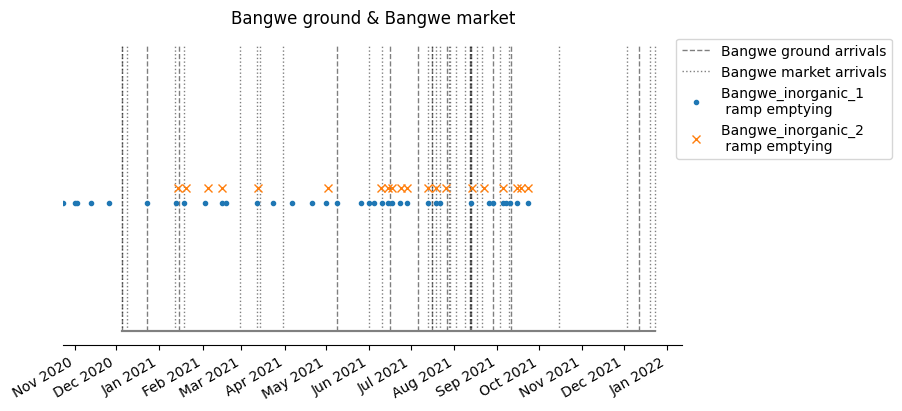

In [855]:
i=0
markers = ['.','x','.']
levels = [0.45,0.5,0.55]
min_date_rates = 0;
max_date_rates = 0;
for binNum in skip_dfCol_indices:
    if type(min_date_rates) is int:
        min_date_rates = min(ramps_empty_events[skip_dfCol[binNum]].dropna().index)
        max_date_rates = max(ramps_empty_events[skip_dfCol[binNum]].dropna().index)
    else:
        min_date_rates = min(min(ramps_empty_events[skip_dfCol[binNum]].dropna().index), min_date_rates)
        max_date_rates = max(max(ramps_empty_events[skip_dfCol[binNum]].dropna().index), max_date_rates)
    plt.plot(ramps_empty_events[skip_dfCol[binNum]].dropna().index.to_pydatetime(),ramps_empty_events[skip_dfCol[binNum]].dropna()*0 + levels[i], marker=markers[i], linestyle='none', markersize=6, label=skip_dfCol[binNum] + " \n ramp emptying")
    i=i+1
    
global_min = (min(min_date_rates,min_date_arrival))
global_max = (max(max_date_rates,max_date_arrival))
limit_min = (max(min_date_rates,min_date_arrival))
limit_max = (min(max_date_rates,max_date_arrival))

plt.legend(bbox_to_anchor=(1.35, 1))
fig = plt.gcf()
plt.xlim(global_min, global_max +  20*td_1) 
fig = plt.gcf()
plt.show()

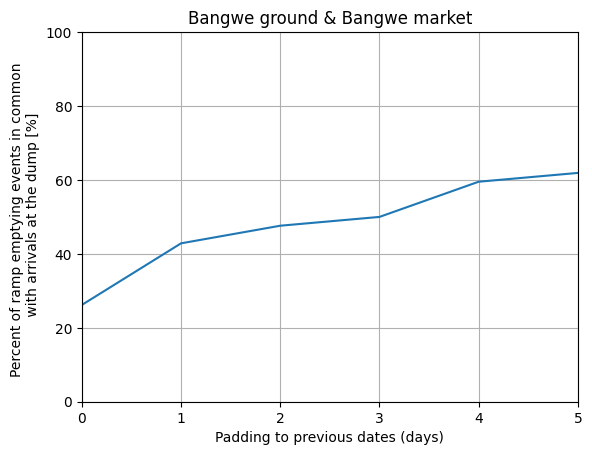

In [858]:
range_margin = 5
#all_arrival_dates
#ramps_empty_events

values_in = np.zeros(range_margin+1)

#median_between_arrivals = np.nanmedian(date_arrival_skip_sort_interm[~date_arrival_skip_sort_interm.index.duplicated(keep='first')].sort_index().index.to_series().diff().dt.days.values)
#print(median_between_arrivals)
ramps_empty_events_dates = ramps_empty_events.index.copy()[ramps_empty_events.index <= limit_max][ramps_empty_events.index.copy()[ramps_empty_events.index <= limit_max] >= limit_min]
values_in = np.zeros(range_margin+1)
for indiv_date in ramps_empty_events_dates:
    for j in range(range_margin + 1):
        offset_date = indiv_date-pd.Timedelta(str(j)+'D')
        if offset_date in all_arrival_dates:
            values_in[j] = values_in[j] + 1
            break
        else:
            pass

plt.plot(range(range_margin+1),100*np.cumsum(values_in)/len(ramps_empty_events_dates))

plt.xlabel('Padding to previous dates (days)')
plt.ylabel('Percent of ramp emptying events in common \n with arrivals at the dump [%]')
# plt.grid()
# plt.legend(bbox_to_anchor = (1,1))
plt.title(title_plt)
plt.xlim(0,range_margin)
plt.grid()
plt.ylim(0,100)

plt.show()
#print(dates_arrival_skip.)#.index.to_series())#.diff().dt.days.values)

In [857]:
values_in

array([11.,  7.,  2.,  1.,  4.,  1.,  1.,  2.,  2.,  0.,  1.,  0.,  2.,
        0.,  0.,  1.,  0.,  2.,  0.,  0.,  0.])